In [27]:
! pip install plotnine


In [28]:
import pandas as pd
from plotnine import *


### Read and preprocess data


In [39]:
df = pd.read_csv("./data/20_data.csv", sep=";")
df.replace("BÜ90/GR", "BÜNDNIS`90/DIE GRÜNEN", inplace=True)
df.replace("DIE LINKE", "DIE LINKE.", inplace=True)
df.drop("Unnamed: 0", axis=1, inplace=True)  # index col
df.head()


,Name,Vorname,Fraktion/Gruppe,20-003-01,20-003-02,20-007-01,20-007-02,20-014-02,20-014-03,20-015-01,20-021-01,20-022-01,20-022-02,20-022-03
0,Aumer,Peter,CDU/CSU,Nein,Ja,Nein,Ja,Nein,Nein,Ja,Ja,Nein,Ja,Ja
1,Bär,Dorothee,CDU/CSU,Nein,Ja,Nein,Ja,Nein,Nein,Abwesend,Ja,Abwesend,Abwesend,Abwesend
2,Bareiß,Thomas,CDU/CSU,Nein,Ja,Nein,Ja,Nein,Nein,Ja,Ja,Nein,Ja,Ja
3,Beyer,Peter,CDU/CSU,Abwesend,Abwesend,Nein,Ja,Nein,Nein,Ja,Ja,Nein,Ja,Ja
4,Bilger,Steffen,CDU/CSU,Nein,Ja,Nein,Ja,Nein,Nein,Ja,Ja,Nein,Ja,Ja


Remove city information and only use 1st firstname


In [30]:
df["Name"] = df["Name"].map(lambda x: x.split("(")[0])
df["Vorname"] = df["Vorname"].map(lambda x: x.split(" ")[0])
df.shape


(742, 14)

If someone switched fraction, merge values


In [31]:
df = df.groupby(["Name", "Vorname"]).apply(lambda x: x.ffill().bfill()).drop_duplicates(subset=["Name", "Vorname"]).reset_index().drop("index", axis=1)
df.shape


(739, 14)

### Pipeline


allowed values for votes: "Ja" = _yes_, "Nein" = _no_, "Enthaltung" = _abstention_, "Ungültig" = _invalid_, "Abwesend" = _not voted_ or NaN


Columns containing the votes are named with the following scheme: {Period}-{Session}-{Poll}


In [32]:
vote_cols = [c for c in df.columns if "-" in c]


In [33]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.manifold import TSNE


In [1]:
preprocess = ColumnTransformer(
    transformers=[
        ("preprocess_vote", Pipeline(
            steps=[
                ('imputer', SimpleImputer(strategy="constant", fill_value="Abwesend")),
                ('onehot', OneHotEncoder())
            ]
        ), vote_cols)
    ],
    sparse_threshold=0)
df_preprocessed = preprocess.fit_transform(df)


NameError: name 'ColumnTransformer' is not defined

Use tSNE for Visualization


In [35]:

tsne = TSNE(n_components=2)
mapping = tsne.fit_transform(df_preprocessed)


In [36]:
df_mapping = pd.DataFrame(mapping, columns=["x", "y"])
df_mapping["name"] = df["Vorname"] + " " + df["Name"]
df_mapping["party"] = df["Fraktion/Gruppe"]
df_mapping.head(20)


,x,y,name,party
0,4.002773,20.504961,Peter Aumer,CDU/CSU
1,10.719733,12.590952,Dorothee Bär,CDU/CSU
2,4.436424,24.128054,Thomas Bareiß,CDU/CSU
3,1.346964,17.565140,Peter Beyer,CDU/CSU
4,1.879826,21.098366,Steffen Bilger,CDU/CSU
5,2.883974,19.637810,Reinhard Brandl,CDU/CSU
6,8.355552,18.932905,Helge Braun,CDU/CSU
7,12.382918,8.387936,Heike Brehmer,CDU/CSU
8,10.974137,11.918363,Ralph Brinkhaus,CDU/CSU
9,4.143567,22.434999,Gitta Connemann,CDU/CSU


In [37]:
colors = {
    "AfD": '#009ee0',
    "FDP": '#ffff00',
    "CDU/CSU": '#000000',
    "SPD": '#E3000F',
    "BÜNDNIS`90/DIE GRÜNEN": '#46962b',
    "DIE LINKE.": '#BE3075',
    "Fraktionslos": "#333333"
}


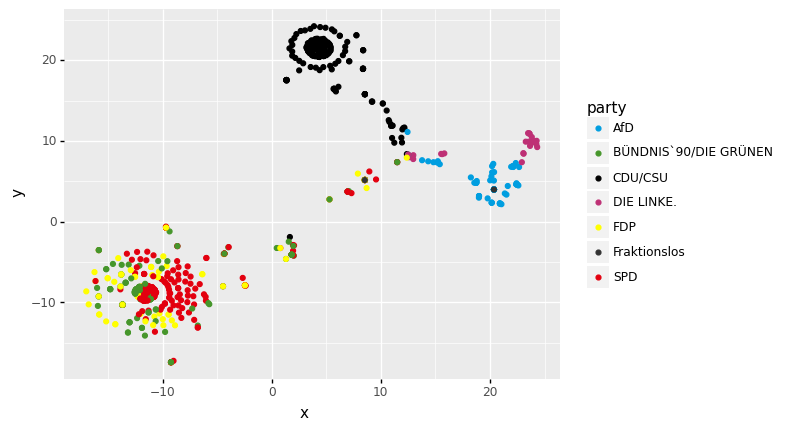

<ggplot: (119883803480)>

In [38]:
ggplot(df_mapping, aes(x="x", y="y", label="name")) + geom_point(aes(colour="party")) + scale_color_manual(values=colors)
